<a href="https://colab.research.google.com/github/shahin-ro/Lung-Cancer-Detection/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports necessary libraries for data handling, image preprocessing, model building, and visualization in Google Colab with TensorFlow and Keras.**

In [29]:
from google.colab import drive
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.pyplot as plt


#**Clones the GitHub repository containing the lung cancer dataset and sets the working directory to the cloned folder.**

In [10]:
!git clone https://github.com/hallowshaw/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning.git
%cd Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning

Cloning into 'Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning'...
remote: Enumerating objects: 886, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 886 (delta 8), reused 3 (delta 0), pack-reused 868 (from 1)
Receiving objects: 100% (886/886), 156.87 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (1005/1005), done.
/content/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning


#**Mounts Google Drive to access or save files, such as the trained model, in the Colab environment.**

In [11]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Defines dataset paths and expected class labels, then cleans directories to ensure only the four specified classes are used.**

In [12]:
dataset_dir = './dataset'
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')

expected_classes = [
    'normal',
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
]

def clean_directory(directory, expected_classes):
    existing_folders = os.listdir(directory)
    print(f"Existing folders in {directory}:", existing_folders)

    for folder in existing_folders:
        if folder not in expected_classes:
            folder_path = os.path.join(directory, folder)
            print(f"Removing unexpected folder: {folder_path}")
            shutil.rmtree(folder_path, ignore_errors=True)

    for cls in expected_classes:
        cls_path = os.path.join(directory, cls)
        os.makedirs(cls_path, exist_ok=True)
        print(f"Ensured folder exists: {cls_path}")
        print(f"Number of images in {cls}:", len(os.listdir(cls_path)))

clean_directory(train_dir, expected_classes)
clean_directory(valid_dir, expected_classes)
clean_directory(test_dir, expected_classes)

print("\nFinal dataset structure:")
print("Training directory:", os.listdir(train_dir))
print("Validation directory:", os.listdir(valid_dir))
print("Test directory:", os.listdir(test_dir))

Existing folders in ./dataset/train: ['large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Ensured folder exists: ./dataset/train/normal
Number of images in normal: 148
Ensured folder exists: ./dataset/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Number of images in adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195
Ensured folder exists: ./dataset/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
Number of images in large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115
Ensured folder exists: ./dataset/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Number of images in squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155
Existing folders in ./dataset/valid: ['large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Ensured folder exists: ./dataset/valid/normal
Number of images i

#**Sets up ImageDataGenerator for data augmentation and loads train, validation, and test datasets with 4 classes.**

In [13]:
IMAGE_SIZE = (350, 350)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=expected_classes,
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=expected_classes,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=expected_classes,
    shuffle=False
)

print("Class indices:", train_generator.class_indices)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 54 images belonging to 4 classes.
Class indices: {'normal': 0, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 1, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


#**Builds and compiles a model using Xception with pre-trained ImageNet weights and a custom 4-class output layer.**

In [14]:
pretrained_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)

pretrained_model.trainable = False

model = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 11, 11, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

#**Trains the model with callbacks for early stopping, learning rate reduction, and model checkpointing, then saves it.**

In [15]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/trained_lung_cancer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, validation_generator.samples // BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model.save('/content/drive/MyDrive/final_lung_cancer_model.h5')

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.3856 - loss: 1.2796
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to /content/drive/MyDrive/trained_lung_cancer_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 768ms/step - accuracy: 0.3866 - loss: 1.2780 - val_accuracy: 0.4583 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 2/50
 1/76 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5000 - loss: 1.0735

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.45833
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5000 - loss: 1.0735 - val_accuracy: 0.4583 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5491 - loss: 0.9746
Epoch 3: val_accuracy improved from 0.45833 to 0.61111, saving model to /content/drive/MyDrive/trained_lung_cancer_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 363ms/step - accuracy: 0.5495 - loss: 0.9740 - val_accuracy: 0.6111 - val_loss: 0.8741 - learning_rate: 0.0010
Epoch 4/50
 1/76 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8750 - loss: 0.6572
Epoch 4: val_accuracy did not improve from 0.61111
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.6572 - val_accuracy: 0.5417 - val_loss: 0.8808 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5929 - loss: 0.8679
Epoch 5: val_accuracy did not improve from 0.61111
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 316ms/step - accuracy: 0.5931 - loss: 0.8679 - val_accuracy: 0.5139 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 6/50
 1/76 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5000 - loss: 0.7476
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.61111
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5000 - loss: 0.7476 - val_accuracy:

#**Evaluates the model on the test set and plots training/validation accuracy and loss curves.**

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7283 - loss: 0.5010
Test Loss: 0.3484
Test Accuracy: 0.8704


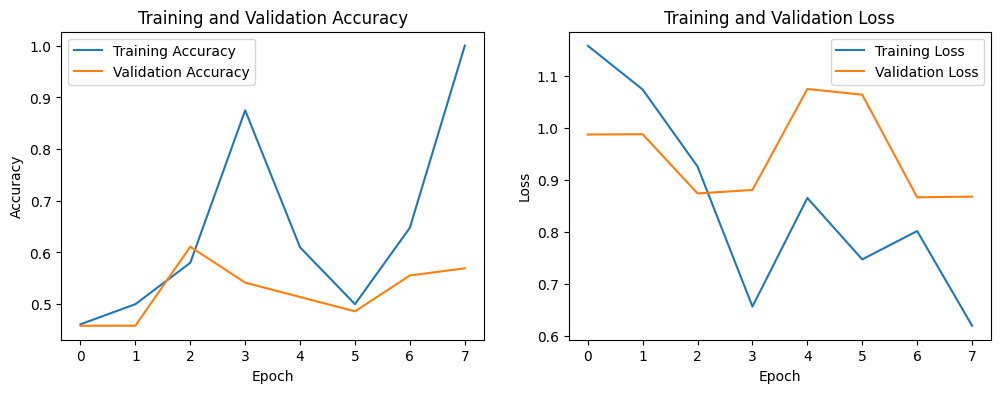

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#**Randomly selects a test image, predicts its class using the trained model, and displays the image with true and predicted labels.**

Selected image: ./dataset/test/normal/8 - Copy.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
True class: normal
Predicted class: normal (Probability: 0.8219)


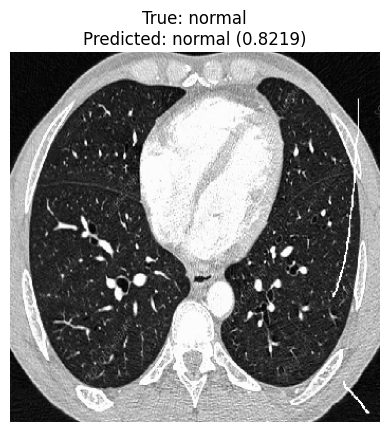

In [25]:
test_dir = './dataset/test'
IMAGE_SIZE = (350, 350)
class_labels = [
    'normal',
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
]

model = load_model('/content/drive/MyDrive/trained_lung_cancer_model.h5')

def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

test_images = []
for class_name in class_labels:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.exists(class_dir):
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        test_images.extend(images)
    else:
        print(f"Warning: Directory {class_dir} not found.")

if not test_images:
    print("Error: No images found in test directory. Please ensure test dataset is populated.")
else:
    img_path = random.choice(test_images)
    print(f"Selected image: {img_path}")

    img_array = load_and_preprocess_image(img_path, IMAGE_SIZE)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_class]

    true_label = os.path.basename(os.path.dirname(img_path))

    print(f"True class: {true_label}")
    print(f"Predicted class: {predicted_label} (Probability: {predictions[0][predicted_class]:.4f})")

    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label} ({predictions[0][predicted_class]:.4f})")
    plt.axis('off')
    plt.show()